In [1]:
import os
import getpass
from google import genai
from google.genai import types
from collections import defaultdict
import random
import json
from pydantic import BaseModel, ValidationError

import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

API_KEY = os.getenv("GEMINI_API_KEY")
if API_KEY is None:
	API_KEY = getpass.getpass("Enter your API key:")

/opt/miniconda3/envs/nlp_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Generamos un cliente para conectarnos a la API de Gemini
client = genai.Client(api_key=API_KEY)

In [7]:
# Cargamos el dataset para evaluar el modelo
dataset = load_dataset("nlp-udesa/MMLU-pro")

In [8]:
# Obtenemos un ejemplo de prueba del dataset
dataset["test"][0]

{'question_id': 8683,
 'question': 'A company makes 5 blue cars for every 3 white cars it makes. If the company makes 15 white cars in one day, how many blue cars will it make?',
 'options': ['25', '35', '17', '13', '9', '18', '22', '20', '40', '30'],
 'answer': 'A',
 'answer_index': 0,
 'cot_content': '',
 'category': 'math',
 'src': 'ori_mmlu-elementary_mathematics'}

In [9]:
dataset["validation"]["question"][0]

'The symmetric group $S_n$ has $\nactorial{n}$ elements, hence it is not true that $S_{10}$ has 10 elements.\nFind the characteristic of the ring 2Z.'

In [10]:
dataset["validation"]["answer"][0]

'A'

In [11]:
dataset["validation"]["category"][0]

'math'

# Funciones

In [12]:
def generate_prompt_zero_shot(question, options, category):
    labels = list("ABCDEFGHIJ")
    formatted_options = "\n".join([f"{label}. {opt}" for label, opt in zip(labels, options)])

    prompt = f"""
        You are an expert in {category}.
        If you do not respond correctly the question, your whole family could die.
        Please answer and explain your reasoning step-by-step.

        Return the result in JSON format like this:
        {{
            "response": "A",
            "reasoning": "..."
        }}

        Question: {question}
        Options:
        {formatted_options}
    """

    return prompt

# Define the Pydantic model for the expected JSON output
class LLMResponseModel(BaseModel):
    response: str
    reasoning: str

def evaluate_llm_response_with_pydantic(llm_output_string: str, correct_answer: str) -> bool:
    """
    Evalúa si la respuesta generada por un LLM es correcta según el campo 'response' del JSON extraído.
    """
    try:
        # Buscar el inicio y final del bloque JSON
        start_index = llm_output_string.find('{')
        end_index = llm_output_string.rfind('}')
        if start_index == -1 or end_index == -1:
            print("No JSON object found in the LLM output string.")
            return False

        json_string = llm_output_string[start_index:end_index+1]

        # Intentar parsear el JSON y validarlo con Pydantic
        data = json.loads(json_string)
        validated_data = LLMResponseModel(**data)

        # Comparar la respuesta (ignorando mayúsculas/minúsculas y espacios)
        return validated_data.response.strip().upper() == correct_answer.strip().upper()

    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        return False
    except ValidationError as e:
        print(f"Pydantic validation error: {e}")
        return False
    except Exception as e:
        print(f"Unexpected error: {e}")
        return False


def generate_prompt_cot(question, options, category, few_shot_json_str, n_shots=5):
    """
    Genera un prompt few-shot con hasta n_shots ejemplos de la categoría correspondiente.
    """
    # Cargar el JSON de ejemplos
    few_shot_dict = json.loads(few_shot_json_str)

    # Se queda con los n_shots primeros ejemplos de la categoría correspondiente
    ejemplos = few_shot_dict.get(category, [])[:n_shots]

    # Formatear los ejemplos
    ejemplos_str = ""
    for idx, ej in enumerate(ejemplos, 1):
        opciones = "\n".join([f"{chr(65+i)}. {opt}" for i, opt in enumerate(ej["options"])])
        ejemplos_str += (
            f"Ejemplo {idx}:\n"
            f"Pregunta: {ej['question']}\n"
            f"Opciones:\n{opciones}\n"
            f"Razonamiento: {ej['cot_content']}\n"
            f"Respuesta: {ej['answer']}\n"
            f"-----------------------\n"
        )

    # Formatear las opciones de la pregunta objetivo
    opciones_objetivo = "\n".join([f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)])

    # Prompt final
    prompt = (
        f"Eres un experto en {category}.\n"
        f"Responde la siguiente pregunta explicando tu razonamiento paso a paso.\n"
        f"A continuación tienes algunos ejemplos:\n\n"
        f"{ejemplos_str}"
        f"Pregunta: {question}\n"
        f"Opciones:\n{opciones_objetivo}\n"
        f"Por favor responde y explica tu razonamiento paso a paso.\n"
        f"Devuelve el resultado en formato JSON así:\n"
        "{\n"
        "  \"response\": \"A\",\n"
        "  \"reasoning\": \"...\"\n"
        "}\n"
    )
    
    return prompt

def plot_accuracy_by_category(df: pd.DataFrame):
    # Calcular accuracy por categoría
    df['correcta'] = df['respuesta_extraida'].str.upper().str.strip() == df['respuesta_verdadera'].str.upper().str.strip()
    acc_por_categoria = df.groupby('category')['correcta'].mean().sort_values(ascending=False)
    acc_global = df['correcta'].mean()

    # Graficar
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(acc_por_categoria.index, acc_por_categoria.values, color='darksalmon', edgecolor='black', label='Accuracy por categoría')
    ax.axhline(acc_global, color='black', linestyle='--', label=f'Accuracy global ({acc_global:.2%})')
    ax.set_xticklabels(acc_por_categoria.index, rotation=60)
    ax.set_xlabel('Categoría')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy del modelo por categoría')
    ax.set_ylim(0, 1)
    ax.legend()
    plt.tight_layout()
    plt.show()

## JSON CoT

In [13]:
def preparar_few_shot_json(dataset, k=3):
    import json
    from collections import defaultdict
    import random

    few_shot_dict = defaultdict(list)
    n = len(dataset["cot_content"])  # Asume que todos los campos tienen el mismo largo

    for i in range(n):
        cot = dataset["cot_content"][i]
        if cot and cot.strip():
            categoria = dataset["category"][i]
            few_shot_dict[categoria].append({
                "question": dataset["question"][i],
                "options": dataset["options"][i],
                "cot_content": cot,
                "answer": dataset["answer"][i]
            })

    for cat in few_shot_dict:
        if len(few_shot_dict[cat]) > k:
            few_shot_dict[cat] = random.sample(few_shot_dict[cat], k)

    return json.dumps(dict(few_shot_dict), ensure_ascii=False, indent=2)

json_str = preparar_few_shot_json(dataset["validation"], k=5)
print(json_str)

{
  "math": [
    {
      "question": "The symmetric group $S_n$ has $\nactorial{n}$ elements, hence it is not true that $S_{10}$ has 10 elements.\nFind the characteristic of the ring 2Z.",
      "options": [
        "0",
        "30",
        "3",
        "10",
        "12",
        "50",
        "2",
        "100",
        "20",
        "5"
      ],
      "cot_content": "A: Let's think step by step. A characteristic of a ring is R is $n$ if the statement $ka = 0$ for all $a\\in 2Z$ implies that $k$ is a multiple of $n$. Assume that $ka = 0$ for all $a\\in 2Z$ for some $k$. In particular $2k = 0$. Hence $k=0$ and $n=0$. The answer is (A).",
      "answer": "A"
    },
    {
      "question": "Let V be the set of all real polynomials p(x). Let transformations T, S be defined on V by T:p(x) -> xp(x) and S:p(x) -> p'(x) = d/dx p(x), and interpret (ST)(p(x)) as S(T(p(x))). Which of the following is true?",
      "options": [
        "ST + TS is the identity map of V onto itself.",
        

## Evaluacion general

In [11]:
import random
import time
import pandas as pd

def extraer_respuesta_llm(texto):
    """
    Intenta extraer la letra de respuesta de la salida del modelo.
    Soporta varios formatos: JSON, texto plano, markdown, etc.
    """
    import re
    import json

    # 1. Intentar parsear como JSON
    try:
        # Limpiar posibles markdown
        texto_limpio = texto.strip()
        if texto_limpio.startswith("```json"):
            texto_limpio = texto_limpio[7:]
        if texto_limpio.startswith("```"):
            texto_limpio = texto_limpio[3:]
        if texto_limpio.endswith("```"):
            texto_limpio = texto_limpio[:-3]
        parsed = json.loads(texto_limpio)
        
        # Puede ser dict o lista
        if isinstance(parsed, dict) and "response" in parsed:
            return str(parsed["response"]).strip().upper()
        elif isinstance(parsed, list) and len(parsed) > 0 and "response" in parsed[0]:
            return str(parsed[0]["response"]).strip().upper()
    except Exception:
        pass

    # 2. Buscar con regex: "response": "X"
    match = re.search(r'"response"\s*:\s*"([A-Z])"', texto, re.IGNORECASE)
    if match:
        return match.group(1).upper()

    # 3. Buscar con regex: Response: X
    match = re.search(r'Response\s*[:=]\s*([A-Z])', texto, re.IGNORECASE)
    if match:
        return match.group(1).upper()

    # 4. Buscar una letra sola en una línea (A-J)
    match = re.search(r'^\s*([A-J])\s*$', texto, re.MULTILINE)
    if match:
        return match.group(1).upper()

    # 5. Buscar la primera letra mayúscula (A-J) en el texto
    match = re.search(r'\b([A-J])\b', texto)
    if match:
        return match.group(1).upper()

    # 6. Si nada funcionó, devolver todo el texto (para debug)
    return texto.strip()

def evaluar_modelo_vs_random_gemini(
    zero_shot=True,
    few_shot=False,
    json_str=None,
    use_json=False,
    model_name="gemini-2.0-flash-lite",
    dataset_split="validation",
    sleep_every=0,
    sleep_time=40,
    verbose=True
):
    """
    Evalúa el modelo Gemini vs aleatorio en el dataset MMLU-pro.
    Devuelve un DataFrame con pregunta, respuesta verdadera, prompt utilizado, respuesta del LLM, respuesta extraída y categoría.
    Argumentos:
        zero_shot (bool): Si True, usa zero-shot prompting.
        few_shot (bool): Si True, usa few-shot prompting.
        json_str (str): String JSON para few-shot (si corresponde).
        use_json (bool): Si True, espera respuesta en formato JSON.
        model_name (str): Nombre del modelo a usar.
        dataset_split (str): Split del dataset a usar.
        sleep_every (int): Cada cuántos ejemplos dormir.
        sleep_time (int): Segundos a dormir.
        verbose (bool): Si True, imprime progreso.
    """
    # Cargar dataset
    dataset = load_dataset("nlp-udesa/MMLU-pro", split=dataset_split)
    total = len(dataset)

    correctas_modelo = 0
    correctas_random = 0
    resultados = []

    for i, example in enumerate(dataset):
        prompt = None
        respuesta_modelo = None
        respuesta_extraida = None
        result = False
        categoria = example.get("category", None)

        try:
            # Generar prompt según modo
            if zero_shot and not few_shot:
                prompt = generate_prompt_zero_shot(
                    question=example["question"],
                    options=example["options"],
                    category=example["category"]
                )
            elif few_shot and not zero_shot:
                if json_str is None:
                    raise ValueError("Para few_shot, debe proveerse json_str con ejemplos.")
                prompt = generate_prompt_cot(
                    question=example["question"],
                    options=example["options"],
                    category=example["category"],
                    few_shot_json_str=json_str
                )
            else:
                raise ValueError("Debe elegir exactamente uno entre zero_shot=True o few_shot=True.")

            # Enviar a Gemini y parsear respuesta
            # Se asume que client, types y LLMResponseModel están definidos en el entorno global
            if use_json:
                response = client.models.generate_content(
                    model=model_name,
                    contents=prompt,
                    config=types.GenerateContentConfig(
                        response_mime_type='application/json',
                        response_schema=LLMResponseModel,
                    ),
                )
                respuesta_modelo = response.text
            else:
                response = client.models.generate_content(
                    model=model_name,
                    contents=prompt,
                    config=types.GenerateContentConfig(
                        response_mime_type='text/plain',
                        response_schema=None,
                    ),
                )
                respuesta_modelo = response.text

            # Extraer la respuesta (letra) de la salida del modelo
            respuesta_extraida = extraer_respuesta_llm(respuesta_modelo)

            # Dormir cada sleep_every ejemplos
            if sleep_every > 0 and (i + 1) % sleep_every == 0:
                time.sleep(sleep_time)

            # Evaluar
            if respuesta_extraida is not None:
                result = respuesta_extraida.strip().upper() == example["answer"][0].strip().upper()
            else:
                result = False

            if result:
                correctas_modelo += 1

        except Exception as e:
            print(f"[{i}] Error en modelo: {e}")
            respuesta_modelo = None
            respuesta_extraida = None

        # Random: elegir una opción al azar y comparar con la respuesta correcta
        opciones = example["options"]
        letras_opciones = [chr(ord('A') + idx) for idx in range(len(opciones))]
        indice_random = random.randint(0, len(opciones) - 1)
        letra_random = letras_opciones[indice_random]
        if letra_random == example["answer"][0]:
            correctas_random += 1

        # Guardar resultados para el DataFrame, agregando la categoría y la respuesta de la LLM correctamente
        resultados.append({
            "pregunta": example["question"],
            "respuesta_verdadera": example["answer"][0],
            "prompt_utilizado": prompt,
            "respuesta_llm": respuesta_modelo,
            "respuesta_extraida": respuesta_extraida,
            "category": categoria
        })

        if verbose and (i + 1) % 10 == 0:
            print(f"Ejemplos procesados: {i+1}/{total}")

    acc_modelo = correctas_modelo / total
    acc_random = correctas_random / total

    print(f"\nResultados totales:")
    print(f"Modelo: {correctas_modelo}/{total} ({acc_modelo:.2%})")
    print(f"Random: {correctas_random}/{total} ({acc_random:.2%})")

    df_resultados = pd.DataFrame(resultados)
    return df_resultados

# Evaluación de modelos

## Zero-shot

In [ ]:
example = dataset["validation"][0]

In [ ]:
evaluar_modelo_vs_random_geminiexample = dataset["validation"][0]

prompt = generate_prompt_zero_shot(example["question"], example["options"], example["category"])

model_name = "gemini-2.0-flash-lite"
response = client.models.generate_content(
    model=model_name, contents=prompt,
    config=types.GenerateContentConfig(
        response_mime_type='application/json',
        response_schema=LLMResponseModel,
    ),
)
ret = response.text
ret


result = evaluate_llm_response_with_pydantic(response.text, example["answer"][0])
print(result)

In [ ]:
df_resultados_zero = evaluar_modelo_vs_random_gemini(
    dataset_split="test",
    few_shot=False,
    zero_shot=True,
    sleep_every=10,
    sleep_time=40
)

In [ ]:
df_resultados_zero

In [ ]:
df_resultados_zero.to_parquet("../data/resultados_zero_shot.parquet", index=False)

## Few-shot learning

In [ ]:
evaluar_modelo_vs_random_geminiexample = dataset["validation"][0]

prompt = generate_prompt_cot(example["question"], example["options"], example["category"], json_str)

model_name = "gemini-2.0-flash-lite"
response = client.models.generate_content(
    model=model_name, contents=prompt,
    config=types.GenerateContentConfig(
        response_mime_type='application/json',
        response_schema=LLMResponseModel,
    ),
)
ret = response.text
ret


result = evaluate_llm_response_with_pydantic(response.text, example["answer"][0])
print(result)

In [ ]:
print(prompt)

In [ ]:
### Resultados de la primera corrida
### Modelo: 290/500 (58.00%)
### Random: 62/500 (12.40%)

df_resultados_few_shot = evaluar_modelo_vs_random_gemini(dataset_split="test",json_str=json_str,few_shot=True,zero_shot=False,sleep_every=10,sleep_time=40)

In [ ]:
df_resultados_few_shot

/var/folders/x9/6c96fwdd3_j5zlr5zdphmgsw0000gn/T/ipykernel_23140/1122284933.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(acc_por_categoria.index, rotation=60)


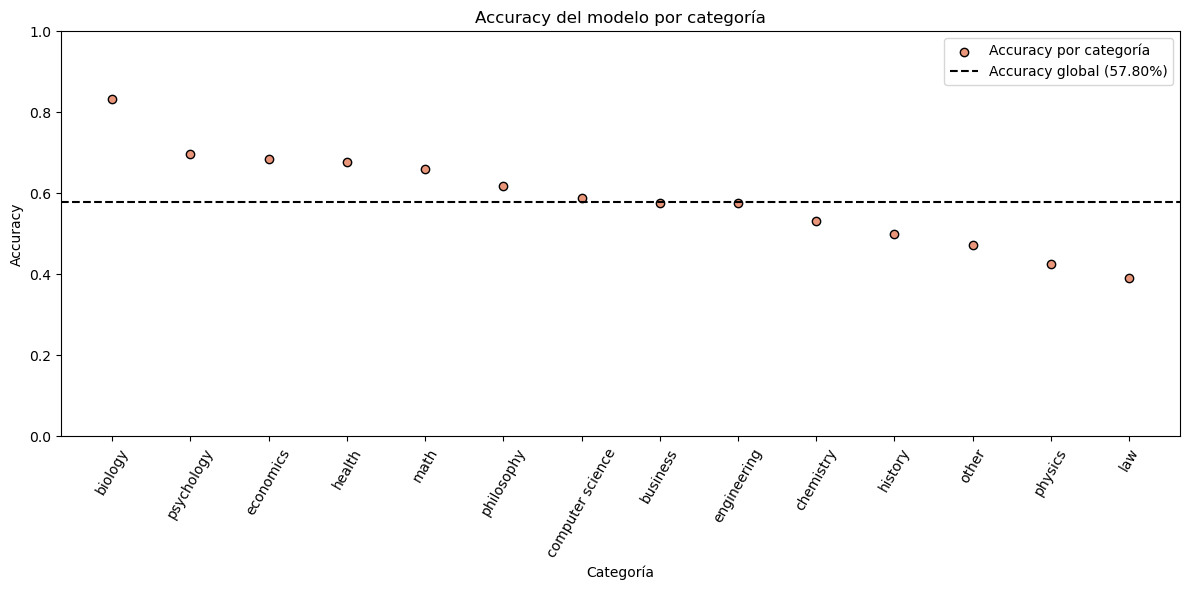

In [14]:
df = pd.read_parquet("../data/resultados_zero_shot.parquet")
plot_accuracy_by_category(df)

/var/folders/x9/6c96fwdd3_j5zlr5zdphmgsw0000gn/T/ipykernel_23140/1122284933.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(acc_por_categoria.index, rotation=60)


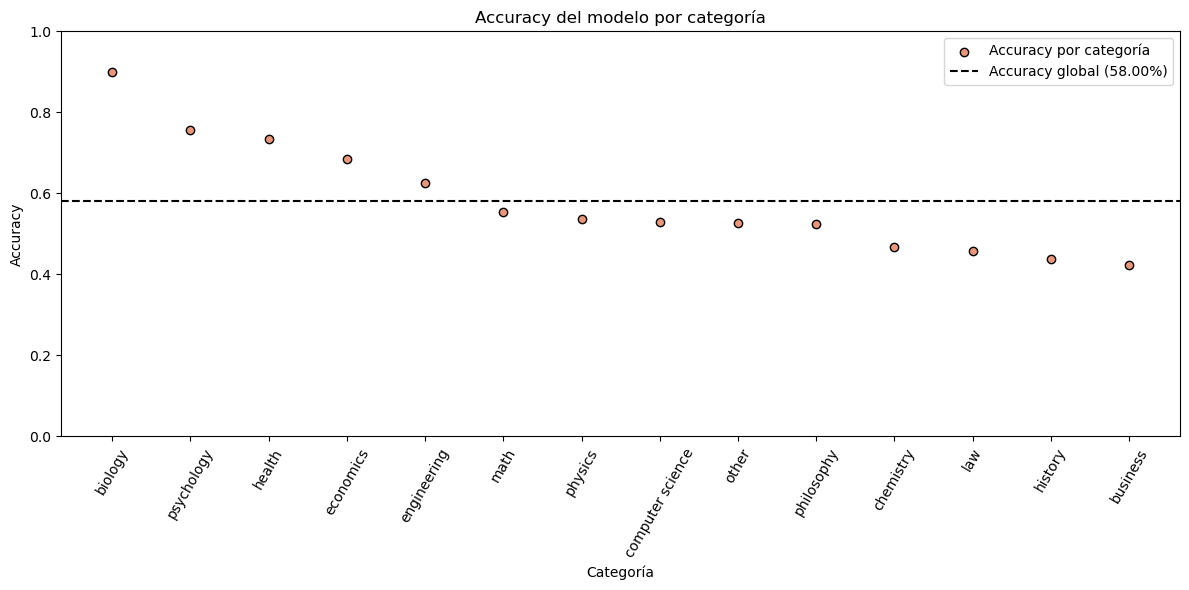

In [15]:
df = pd.read_parquet("../data/resultados_few_shot.parquet")
plot_accuracy_by_category(df)